In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read the network

Let us read the network and store it into a numpy array. Each row corresponds to a different contact.

Each edge (row) is characterised by 4 features(the 4 columns of the array).

- The timing of the contact
- The identities of the nodes involved in the contact
- The weight associated to the contact 

In [2]:
#Temporal network from M. Salathé, et al., PNAS 2010 107 (51) 22020-22025
#https://www.pnas.org/content/107/51/22020

net = np.loadtxt('LAB5_school_salathe.csv').astype(int) # read network
print(net[:10,:]) # print first contacts

[[  0   4 287   1]
 [  0  12 287   1]
 [  0  14 287   1]
 [  0  15 416   1]
 [  0  15 705   2]
 [  0  15 738   1]
 [  0  39 287   1]
 [  0  43  50  12]
 [  0  43 200   2]
 [  0  43 520   2]]


## Plot the number of active nodes

In [4]:
def get_node_activity(network):
    '''
    This function computes the number of active nodes during each time step
    
    Output:
    1) List of snapshot timings
    2) List with number of active nodes
    
    '''
    res = []
    times = np.unique(network[:,0]) # get snapshot timing
    times = sorted(times) # put times in increasing order
    
    # now loop over times, get the corresponding snapshot 
    # and compute the number of unique node ids involved
    for t in times:
        snapshot = network[network[:,0] == t]
        res.append( len( np.unique(snapshot[:,1:3]) ) )
    
    return times, res

Text(0, 0.5, '# active nodes')

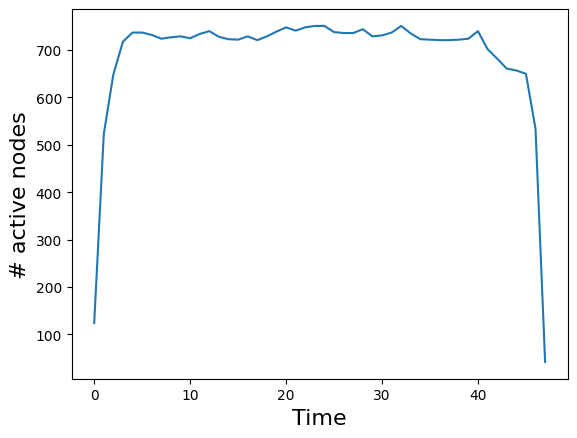

In [5]:
# To obtain the number of active nodes, first split the network into snapshots 
# Then count the number of unique node ids in that snapshot. 

times, active_nodes = get_node_activity(net)
plt.plot(times, active_nodes)

plt.xlabel('Time', fontsize = 16)
plt.ylabel('# active nodes', fontsize = 16)

## Plot number of active links

In [6]:
def get_link_activity(network):
    '''
    This function computes the number of active links during each time step
    
    Output:
    1) List of snapshot timings
    2) List with number of active links
    
    '''
    res = []
    times = np.unique(network[:,0]) # get snapshot timing
    times = sorted(times) # put times in increasing order
    
    # now loop over times, get the corresponding snapshot 
    # and compute the number of contacts involved
    for t in times:
        snapshot = network[network[:,0] == t]
        res.append( len(snapshot[:,1:3] ) )
    
    return times, res

Text(0, 0.5, '# active links')

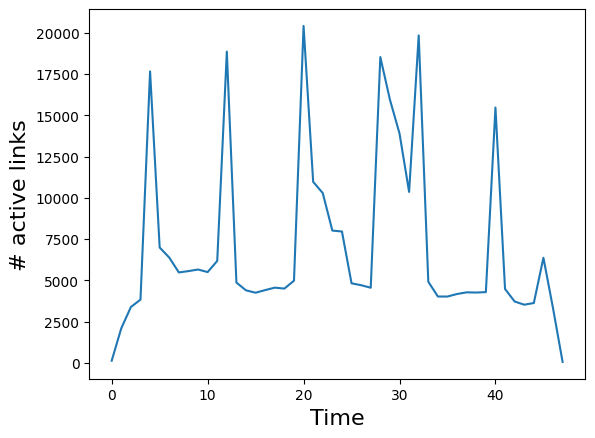

In [7]:
# To obtain the number of active links, first split the network into snapshots 
# Then count the number of rows corresponding to that snapshot 

times, active_links = get_link_activity(net)
plt.plot(times, active_links)

plt.xlabel('Time', fontsize = 16)
plt.ylabel('# active links', fontsize = 16)

## Simulate SIR dynamics

In [8]:
def simulate_SIR(t_max, tr, rec, network, N0):
    '''
    This functions simulates a SIR process on a temporal network
    
    Arguments:
    
    1) t_max: number of simulation time steps; if t_max is larger than the duration of the network, 
    periodic boundary conditions are applied. The simulation may stop earlier if the epidemics dies out.
    
    2) tr: per-contact probability to transmit the disease from an infected individual to a susceptible one 
    during a single time step 
    
    3) rec: probability to become recovered during a single time step
    
    4) N0: number of initially infected individuals
    
    Output:
    
    a list containing the prevalence during each time step
    
    '''
    
    T = np.amax(network[:,0]) # get network duration (the period)
    node_labels = np.unique( network[:, 1:3])  # get nodes' labels
    
    state = {i: 'S' for i in node_labels} # set all nodes as susceptibles ('S')
    
    #===== Seed the infection =====#
    
    first_nodes = np.unique( network[ network[:,0] == 0 ][:, 1:3]) # select all nodes appearing in the first snapshot
    
    # Choose N0 individuals at random among the nodes that appear in the first snapshot 
    if N0 < len(first_nodes):
        seeds = np.random.choice(first_nodes, size = N0, replace = False)
    else:
        seeds = first_nodes
    
    # Set the chosen nodes to infected (I)
    for seed in seeds:
        state[seed] = 'I'
        
    prevalence = [min(N0, len(first_nodes))] # This list will store the results
    
    #===== Start the simulation =====#
    
    for t in range(t_max):
        snapshot = network[ network[:,0] == t % T ] # select the snapshot (use t mod T in order to use periodic boundary conditions)    
        new_infected = [] # This list will store the nodes that will become infected during this time step
        
        # loop over contacts in the current snapshot
        for edge in snapshot[:,]:
            s1 = state[ edge[1] ]
            s2 = state[ edge[2] ]
            
            # check if the contact is between a susceptible and an infected node
            if ( (s1 == 'S') and (s2 == 'I') ) or  ( (s2 == 'S') and (s1 == 'I') ) :
                
                if s1 == 'S':
                    target_node = edge[1]
                else:  
                    target_node = edge[2]
                    
                # check if infection occurs with probability given by the transmissibility ('tr')
                # if infection occurs, do not set the susceptible node infected straight away
                # but store this information in 'new_infected'.
                # Also check that the susceptible node has not been infected yet!
                if target_node not in new_infected:
                    if np.random.random() < tr:
                        new_infected.append( target_node )
                        
        # loop over nodes; if a node is infected, it recovers with probability given by 'rec' and its
        # status is set to 'R'
        for node, s in state.items():
            if s == 'I':
                if np.random.random() < rec:
                    state[node] = 'R'
        
        # finally update the status of nodes that have been successfully infected
        for node in new_infected:
            state[node] = 'I'
          
        # Compute the prevalence and store it
        prev = len([node for node, s in state.items() if s == 'I'])
        prevalence.append(prev)
        
        # if there no infected halt the simulation
        if prev == 0:
            break
            
    return prevalence

In [9]:
t_max = 200 # maximum simulation time
transmissibility = 0.1 # infection probability
recovery = 0.05 # recovery probability
N0 = 1 # initial seeds

# simulate SIR dynamics and obtain prevalence
prevalence = simulate_SIR(t_max, tr = transmissibility, rec = recovery,
            network = net, N0 = N0)

Text(0, 0.5, 'Prevalence')

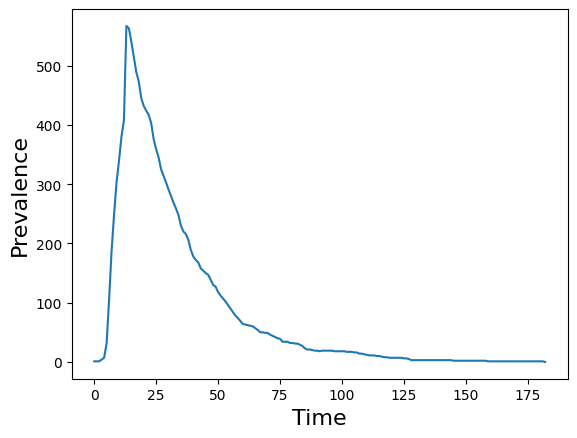

In [11]:
plt.plot(prevalence)

plt.xlabel('Time', fontsize = 16)
plt.ylabel('Prevalence', fontsize = 16)

## Random reference models

In [20]:
def RRM_reshuffle(network):
    '''
    This function randomly shuffles the snapshot time ordering.
    It therefore breaks the temporal activity as well as correlations between link activations
    while preserving the properties of the aggregated network.
    
    See also the paper "Infection propagator approach to compute epidemic thresholds
    on temporal networks: impact of immunity and of limited
    temporal resolution", by Eugenio Valdano, Chiara Poletto and Vittoria Colizza, 
    European Physical Journal B, 2015.
    
    '''
    network2=np.copy(network)
    times = np.unique(network[:,0]) # get snapshot timing
    times = sorted(times) # put times in increasing order
    
    randomized_times=np.copy(times)
    np.random.shuffle(randomized_times)        

    for i in range(len(times)):             #swap old times with reshuffled
        network2[network[:,0]==times[i],0]=randomized_times[i]     

    return network2
    
   
    
def RRM_anonymize(network):
    '''
    This function reshuffles the identity of the nodes of each time snapshot,
    thus preserving activity timeline and static topology of
    each snapshot. It breaks all dynamic community structures and cliques.
    
    See also the paper "Infection propagator approach to compute epidemic thresholds
    on temporal networks: impact of immunity and of limited
    temporal resolution", by Eugenio Valdano, Chiara Poletto and Vittoria Colizza, 
    European Physical Journal B, 2015.
    '''
    network2 = np.copy(network)

    times = np.unique(network[:,0]) # get snapshot timing
    times = sorted(times) # put times in increasing order
    nodes=np.unique(network[1:3])
    nodes=sorted(nodes)
    
    for t in times:
        randomized_nodes=np.copy(nodes)
        np.random.shuffle(randomized_nodes)

        for i in range(len(nodes)):             #swap old nodes with reshuffled
            network2[(network2[:,0] == t) & (network2[:,1]==nodes[i]),1]=randomized_nodes[i]      
            network2[(network2[:,0] == t) & (network2[:,2]==nodes[i]),2]=randomized_nodes[i]      

    return network2
    

In [21]:
# Apply randomization schemes
net_reshuffle = RRM_reshuffle(net)
net_anonymize = RRM_anonymize(net)

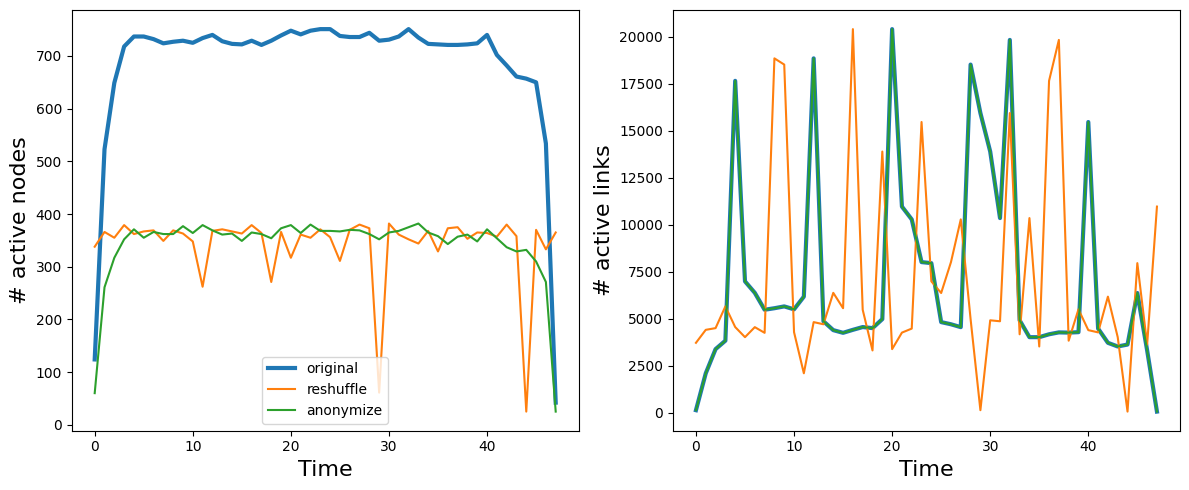

In [22]:
# compute node and link activity and compare with original network

fig, ax = plt.subplots(ncols = 2, figsize = (12, 5), sharex = True)

times1, active_nodes_reshuffle = get_node_activity(net_reshuffle)
times2, active_nodes_anonymize = get_node_activity(net_anonymize)

ax[0].plot(times, active_nodes, lw = 3, label = 'original')
ax[0].plot(times1, active_nodes_reshuffle, label = 'reshuffle')
ax[0].plot(times2, active_nodes_anonymize, label = 'anonymize')

#==== Now plot active links ====#

times1, active_links_reshuffle = get_link_activity(net_reshuffle)
times2, active_links_anonymize = get_link_activity(net_anonymize)

ax[1].plot(times, active_links, lw = 3)
ax[1].plot(times1, active_links_reshuffle)
ax[1].plot(times2, active_links_anonymize)

#==== Figure settings ====#

ax[0].set_xlabel('Time', fontsize = 16)
ax[1].set_xlabel('Time', fontsize = 16)

ax[0].set_ylabel('# active nodes', fontsize = 16)
ax[1].set_ylabel('# active links', fontsize = 16)

ax[0].legend(loc = 'lower center')

plt.tight_layout()

In [23]:
# simulate SIR dynamics on random reference models 
prevalence_reshuffle = simulate_SIR(t_max, tr = transmissibility, rec = recovery,
            network = net_reshuffle, N0 = N0)

prevalence_anonymize = simulate_SIR(t_max, tr = transmissibility, rec = recovery,
            network = net_anonymize, N0 = N0)

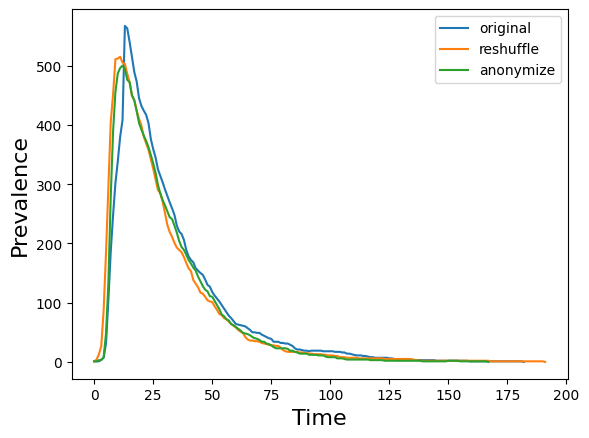

In [24]:
# plot simulation results
plt.plot(prevalence, label = 'original')
plt.plot(prevalence_reshuffle, label = 'reshuffle')
plt.plot(prevalence_anonymize, label = 'anonymize')

plt.xlabel('Time', fontsize = 16)
plt.ylabel('Prevalence', fontsize = 16)

plt.legend()